# **💭 Cognitive Distortion Classification - Multiclass Classification Using TensorFlow**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("Paired")

In [ ]:
sns.color_palette()

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [ ]:
palette = sns.color_palette()

For this model, I will use TensorFlow version 2.13.x.

In [ ]:
# !pip install tensorflow==2.13.0 tensorflow-hub tensorflow-text==2.13.0

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
print(tf.__version__)
print(hub.__version__)
print(text.__version__)

2.13.0
0.16.1
2.13.0


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Practica/cognitive_distortions_to_model.csv')
df.head()

,id,patient_question,distorted_part,dominant_distortion,secondary_distortion,patient_speech,label
0,4604,I’m worried about my thoughts about my friend....,At first I tried to help and it wasn’t easy as...,All-or-nothing thinking,NaN,At first I tried to help and it wasn’t easy as...,0
1,1482,Hi :) So I recently broke up with my boyfriend...,He’s not there for me at my worst so he doesn’...,All-or-nothing thinking,NaN,He’s not there for me at my worst so he doesn’...,0
2,1165,"I’m a 25yo male, i’ve been diagnosed with depr...",I’ve stopped seeing any doctors and i’m about ...,All-or-nothing thinking,NaN,I’ve stopped seeing any doctors and i’m about ...,0
3,74,I get suicidal thoughts sometimes. I know I wo...,I often think I am a failure but sometime in a...,All-or-nothing thinking,NaN,I often think I am a failure but sometime in a...,0
4,2337,"I am 23 years old, and a female. I have never ...",I don’t know what I am feeling and it scares t...,All-or-nothing thinking,NaN,I don’t know what I am feeling and it scares t...,0


In [ ]:
df.shape

(1100, 7)

**Splitting the data into train, validation and test splits**
* Training: 60% of the data
* Validation: 20% of the data
* Test: 20% of the data

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

#Splitting into train, validation, and test sets

train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    df['patient_speech'].to_numpy(), df['label'].to_numpy(), test_size=0.4, random_state=42)

val_sentences, test_sentences, val_labels, test_labels = train_test_split(
    temp_sentences, temp_labels, test_size=0.5, random_state=42)

#Checking the lenghts

len(train_sentences), len(train_labels), len(val_sentences), len(val_labels), len(test_sentences), len(test_labels)

(660, 660, 220, 220, 220, 220)


##🤖 **Modeling the Dataset**

Continuing the experiment with the following models:

* **Model 8:** TensorFlow Hub BERT Base Pretrained Encoder

* **Model 9:** Hugging Face BERT

In each experiment I will:

* Build a model

* Train (fit) the model

* Make predictions with the model

* Evaluate the model using different metrics for comparison (accuracy, precision, recall, f1 score)




### **Model 8: Transfer Learning with TensorFlow Hub - BERT Base (Pretrained Encoder)**

In [ ]:
from tensorflow.keras import layers

#BERT preprocessing and encoding layers

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="bert_preprocess")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", name="bert_encoder")

input_text = layers.Input(shape=(), dtype=tf.string, name="input_text")
preprocessed_text = bert_preprocess(input_text)
encoded_text = bert_encoder(preprocessed_text)['pooled_output']  #Using pooled output for classification tasks
x = layers.Dense(64, activation='relu')(encoded_text)
output = layers.Dense(11, activation='softmax')(x)

model_8 = tf.keras.Model(inputs=input_text, outputs=output, name="model_8_BERT")

In [ ]:
model_8.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_8.summary()

Model: "model_8_BERT"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 bert_preprocess (KerasLaye  {'input_type_ids': (None,    0         ['input_text[0][0]']          
 r)                          128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                       

In [ ]:
#Function to create TensorBoard callbacks

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instance to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
#Creating directory to save TensorBoard logs

SAVE_DIR = "model_logs"

In [ ]:
model_8_history = model_8.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder_bert")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_bert/20241001-084325
Epoch 1/5
21/21 [==============================] - 518s 24s/step - loss: 2.4336 - accuracy: 0.1152 - val_loss: 2.4134 - val_accuracy: 0.1227
Epoch 2/5
21/21 [==============================] - 527s 25s/step - loss: 2.3265 - accuracy: 0.1848 - val_loss: 2.3360 - val_accuracy: 0.1455
Epoch 3/5
21/21 [==============================] - 504s 24s/step - loss: 2.2900 - accuracy: 0.1894 - val_loss: 2.3330 - val_accuracy: 0.1273
Epoch 4/5
21/21 [==============================] - 499s 24s/step - loss: 2.2822 - accuracy: 0.1833 - val_loss: 2.3532 - val_accuracy: 0.1318
Epoch 5/5
21/21 [==============================] - 476s 23s/step - loss: 2.2516 - accuracy: 0.1924 - val_loss: 2.3020 - val_accuracy: 0.1318


In [ ]:
model_8.evaluate(val_sentences, val_labels)

7/7 [==============================] - 116s 17s/step - loss: 2.3020 - accuracy: 0.1318


[2.3020195960998535, 0.13181817531585693]

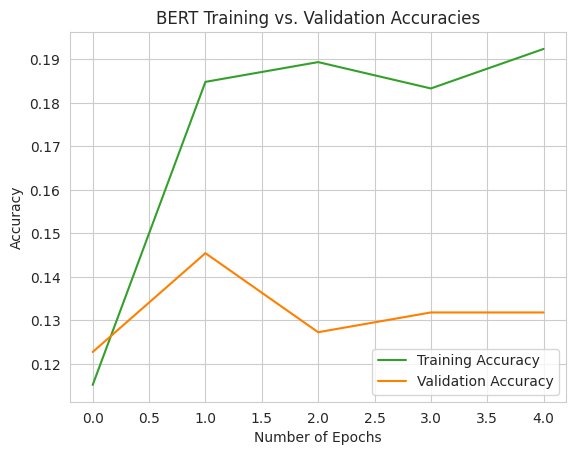

In [ ]:
plt.plot(model_8_history.history['accuracy'], label='Training Accuracy', color=palette[3])
plt.plot(model_8_history.history['val_accuracy'], label = 'Validation Accuracy', color=palette[7])
plt.title('BERT Training vs. Validation Accuracies')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend();

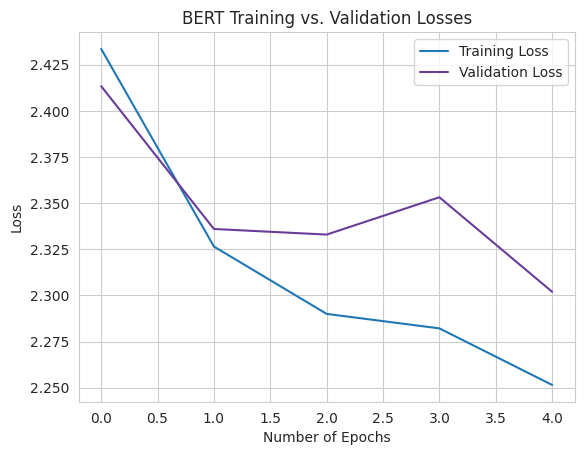

In [ ]:
plt.plot(model_8_history.history['loss'], label='Training Loss', color=palette[1])
plt.plot(model_8_history.history['val_loss'], label = 'Validation Loss', color=palette[9])
plt.title('BERT Training vs. Validation Losses')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend();

In [ ]:
#Making predictions on the validation dataset

model_8_pred_probs = model_8.predict(val_sentences)
model_8_pred_probs.shape, model_8_pred_probs[:10]

7/7 [==============================] - 138s 18s/step


((220, 11),
 array([[0.0816875 , 0.09216656, 0.0842713 , 0.08211116, 0.09305828,
         0.10926186, 0.09652051, 0.03923904, 0.11259072, 0.10255385,
         0.10653918],
        [0.08399842, 0.11756731, 0.02920624, 0.11932147, 0.11134954,
         0.0839735 , 0.07794288, 0.16947037, 0.10523673, 0.05829612,
         0.04363745],
        [0.07720995, 0.06636015, 0.12429214, 0.08463577, 0.05705366,
         0.06890056, 0.13255844, 0.0194373 , 0.08029304, 0.13590196,
         0.15335712],
        [0.12707728, 0.05555381, 0.08308022, 0.11016138, 0.06097626,
         0.07274906, 0.12272953, 0.05451191, 0.06813767, 0.14793111,
         0.09709184],
        [0.09277311, 0.08631088, 0.08579404, 0.10135683, 0.08887256,
         0.08007088, 0.11236008, 0.03282031, 0.09814969, 0.11124513,
         0.11024643],
        [0.09571275, 0.08726894, 0.0672552 , 0.10794339, 0.09290798,
         0.08978985, 0.09784064, 0.05384981, 0.12096037, 0.09574681,
         0.09072429],
        [0.0624583 , 0.09032

In [ ]:
#Turning prediction probabilities into 1D tensors

model_8_preds = tf.argmax(model_8_pred_probs, axis=1)
model_8_preds[:20]

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([ 8,  7, 10,  9,  6,  8, 10, 10,  8,  5,  8, 10,  6, 10,  7,  8,  8,
        8,  9,  3])>

0 - All-or-nothing thinking

1 - Emotional reasoning

2 - Fortune telling

3 - Labeling

4 - Magnification

5 - Mental filter

6 - Mind reading

7 - No distortion

8 - Overgeneralization

9 - Personalization

10 - Should statements

In [ ]:
#Evaluation function (y_true, y_pred are 1D arrays)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
#Calculating LSTM model results

model_8_results = calculate_results(y_true=val_labels, y_pred=model_8_preds)
model_8_results

{'accuracy': 13.18181818181818,
 'precision': 0.06967087139335944,
 'recall': 0.1318181818181818,
 'f1': 0.07712997087997088}